# Proyecto Final: Comparación de un método de tipo Montecarlo y un Método de Resolución Directa de una EDP

* Curso: Análisis Numérico de Ecuaciones en Derivadas Parciales: Teoría y Laboratorio (MA5307)
* Profesor: Axel Osses A.
* Profesor Auxiliar: Emir N. Chacra
* Estudiantes: Johnny Godoy, Javier Santidrián Salas, Patricio Yañez A.
* Fecha: 17/06/22

#Motivación
En este proyecto buscamos comparar algoritmos de tipo Montecarlo con algoritmos de Diferencias Finitas para la resolución de una EDP, ya sea en términos de eficacia (error de aproximación), eficiencia (tiempo de ejecución) y la complejidad de código (escalabilidad a otros parámetros y problemas). Exploramos distintos métodos y variaciones de ellos, incluso proponiendo los nuestros, estudiando las ventajas y desventajas de cada uno.  

## Imports y configuraciones

In [1]:
from __future__ import annotations  # Declaracion de tipos

import dataclasses  # Librería para OOP
import itertools
import multiprocessing.pool
import platform
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import tabulate

In [2]:
module_path = f"{os.path.abspath(os.path.join('..'))}\\src"
if module_path not in sys.path:
    sys.path.append(module_path)

from _utilities import get_random_walk
from finite_difference_solver import FiniteDifferenceSolver
from hybrid_solver import HybridSolver
from monte_carlo_solvers import FrequentistSolver, LaplaceSmoothingSolver, ManhattanSmoothingSolver
from poisson_problem import PoissonProblem
from subwalk_monte_carlo_solvers import SingleThreadSMCSolver, MultiThreadSMCSolver

print(f"\n{tabulate.tabulate(platform.uname()._asdict().items())}")


---------  -----------------------------------
system     Linux
node       12a89b9d752c
release    5.4.188+
version    #1 SMP Sun Apr 24 10:03:06 PDT 2022
machine    x86_64
processor  x86_64
---------  -----------------------------------


In [3]:
#fijamos dimensiones y estilo de gráficos
plt.style.use('default')
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})

random.seed(0)
RNG = np.random.default_rng()

In [4]:
# Queremos graficos anidados pero a escala original
def subplots(nrows, ncols):
    a, b = plt.rcParams["figure.figsize"]
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*a, nrows*b),
                             constrained_layout=True)
    return fig, axes

# EDP a resolver

En este proyecto nos concentraremos en resolver la ecuación de Poisson con condiciones de Dirichlet:

$$
\begin{equation}
\left.
\begin{array}[c]{rll}
-\Delta u=& f & \text{sobre }\Omega\\
u =& g & \text{en }\partial \Omega \\
\end{array}
\right\}
\end{equation}
$$

El código será capaz de resolver cualquiera de estos casos, pero para la realización de experimentos consideramos la misma EDP que en el laboratorio 1:

$$
\begin{equation}
\left.
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left[  0,1\right]^{2}\\
u(0,y)=u(1,y)= & 0 & \text{en }0\leq y\leq 1\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & \sin(\pi x) & \text{en }0\leq x\leq 1
\end{array}
\right\} \quad (1)
\end{equation}
$$

y como conocemos la solución analítica de este problema:


$$u\left(  x,y\right)  =\frac{\sin\left( \pi x\right)   \sinh\left( \pi y\right)  }{\sinh\left(  \pi\right) } $$

esto nos permitirá comparar los errores de la solución.

# Algoritmos Montecarlo
Los algoritmos a utilizar se basan en simular un paseo aleatorio simple desde un punto $x_0\in \text{int}(\Omega)$ hasta que llegue a un punto $\xi\in\partial\Omega$. 

### Visualizando un paseo aleatorio

Fijando parámetros

In [5]:
discretization = 5
h = 1/(discretization + 1)
side = np.arange(discretization + 2)
i, j = 3, 4

Simulando el paseo

In [6]:
i_walk, j_walk, walk = get_random_walk(i, j, discretization + 1)
walk.append((i_walk, j_walk))
# walk = [(3, 4), (3, 3), (3, 2), (2, 2), (1, 2), (0, 2)]
grid = np.zeros((discretization + 2, discretization + 2))
for i, step in enumerate(walk, 1):
    x, y = step
    grid[x, y] = 1

Visualizando el paseo

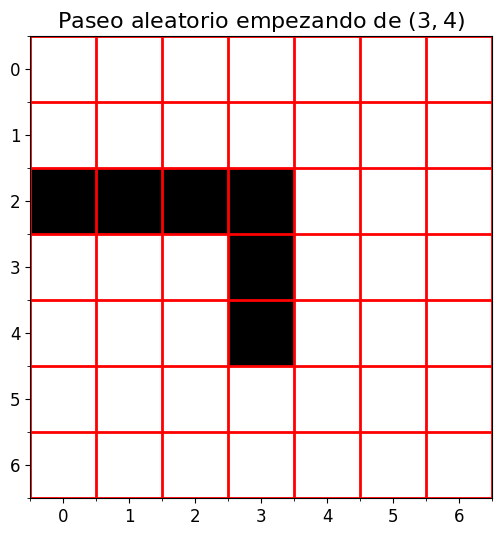

In [7]:
plt.figure()
im = plt.imshow(grid.T, interpolation='none', vmin=0, vmax=1, aspect='equal', cmap="binary")

ax = plt.gca();

# Major ticks
ax.set_xticks(side)
ax.set_yticks(side)

# Labels for major ticks
ax.set_xticklabels(side)
ax.set_yticklabels(side)

# Minor ticks
ax.set_xticks(np.arange(-.5, discretization + 2), minor=True)
ax.set_yticks(np.arange(-.5, discretization + 2), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='r', linestyle='-', linewidth=2)
ax.set_title(r"Paseo aleatorio empezando de $(3, 4)$");

## Algoritmo Propuesto del Reporte de Referencia

El algoritmo propuesto recibe como entrada un $x_0\in\text{int}(\Omega)$ y aproxima $u(x_0)$ como sigue:


0. Inicializar un diccionario que asocia los puntos de borde $\xi\in\partial\Omega$ al valor 0.
1. Repetir $W$ veces: 

    1.1.  Correr un paseo aleatorio $w$ desde $x_0$ hasta llegar a un punto de borde $\xi$

    1.2.   Calcular $F(w) = \sum_{i\in w\setminus \{\xi\}} f(i)h^2$
    
    1.3.   Actualizar el diccionario $C[\xi] += 1$

2. Calcular la probabilidad de llegar a cada punto de borde como $P(\xi) = \frac{C[\xi]}{W}$
3. Retornar $u(x_0) = \sum_{\xi\in\partial\Omega} P(\xi)g(\xi) - \sum_w F(w)$

## Estimación bayesiana

En el paso 3 calculamos la probabilidad desde un enfoque frecuentista. En particular, si el evento de caer en un punto de borde no ocurre, se le asigna probabilidad 0, lo cual puede problemático, pues el evento no necesariamente es imposible. 

Esto ocurre si es que no se corren suficientes iteraciones $W$. Si queremos que se llegue a puntos del borde, necesitamos al menos $O(n)$ iteraciones para cada punto $x_0$. 

Entonces, proponemos utilizar un estimador bayesiano con prior conjugado Dirichlet de parámetro $\alpha$:

$$
P(\xi) = \frac{C[\xi] + \alpha_\xi}{W + \sum_{\kappa\in\partial\Omega} \alpha_\kappa}
$$

En el denominador el término $\sum_{\kappa\in\partial\Omega} \alpha_\kappa$ se interpreta como nuestra **confianza en el prior.**

Nuestras dos propuestas de prior son las siguientes:

$$
\alpha_\xi = \dfrac{1}{2\sum_{\kappa\in\partial\Omega} g(\kappa)} \, \forall \xi\in\partial\Omega\\
\alpha_\xi =\frac{1}{|i - \xi_i| + |j - \xi_j|} \, \forall \xi\in\partial\Omega
$$

El primero es un prior constante, escalado para que valores altos de $g$ no tengan demasiada influencia. El segundo prior supone que los puntos más cercanos (en sentido $L^1$) son más probables para el paseo aleatorio -  este supuesto utiliza la convexidad del dominio y falla sin tenerla.

### Implementación de distintos estimadores

### Comparación de priors

Visualizaremos las soluciones para cada uno de los estimadores propuestos utilizando 50 puntos para la discretización y 30 paseos aleatorios, comparando su error con respecto a la solución analítica.

In [8]:
def u_analitica(N):
    X, Y = np.meshgrid(np.linspace(0, 1, N+2), np.linspace(0, 1, N+2))
    return np.sin(np.pi*X)*np.sinh(np.pi*Y)/np.sinh(np.pi)

problema = PoissonProblem(50)

def plot_solution(solver):
    shw = plt.imshow(solver.grid, origin="bottom")
    bar = plt.colorbar(shw)
    plt.title(f"Estimación {solver}");

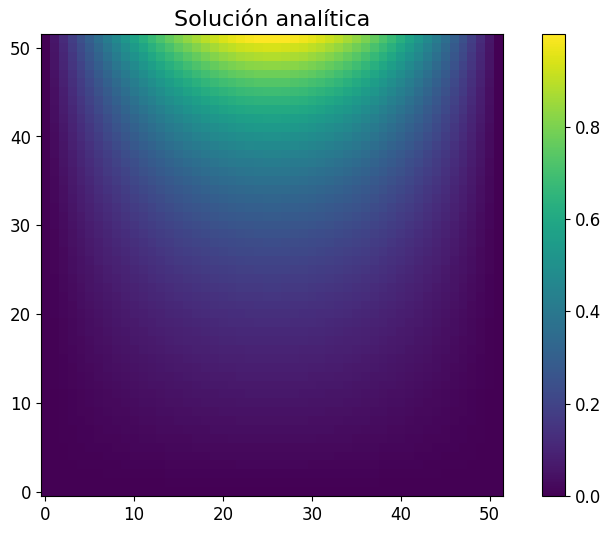

In [9]:
shw = plt.imshow(u_analitica(50), origin="bottom")
bar = plt.colorbar(shw)
plt.title("Solución analítica");

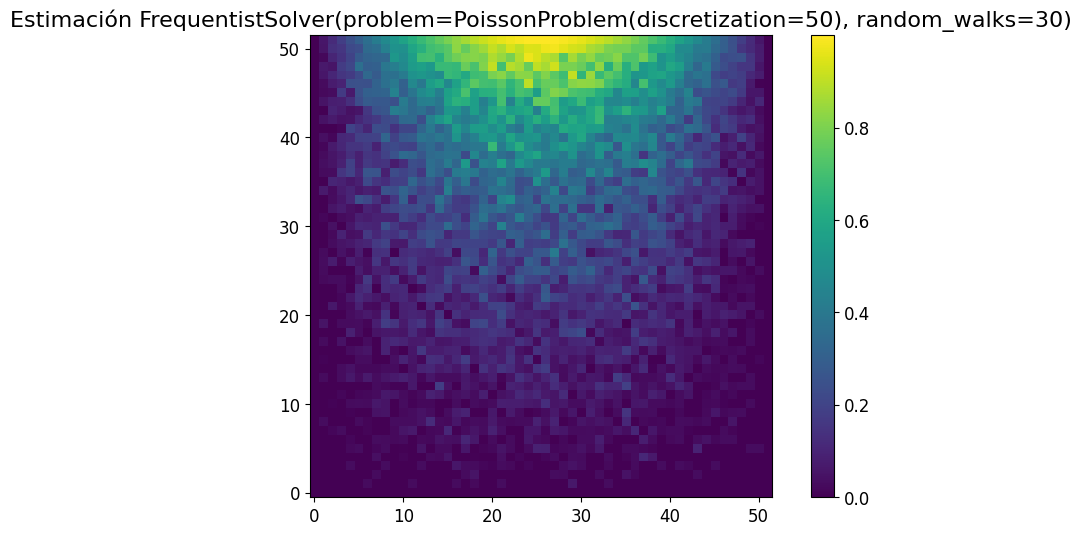

In [10]:
frequentist = FrequentistSolver(problema, 30)
plot_solution(frequentist)

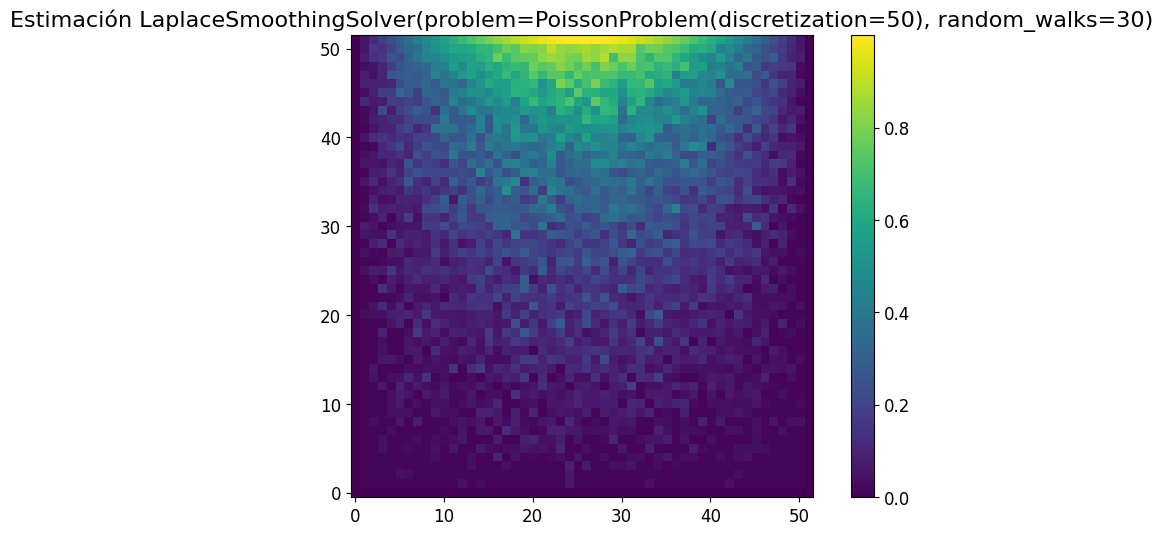

In [11]:
laplace_smoothing = LaplaceSmoothingSolver(problema, 30)
plot_solution(laplace_smoothing)

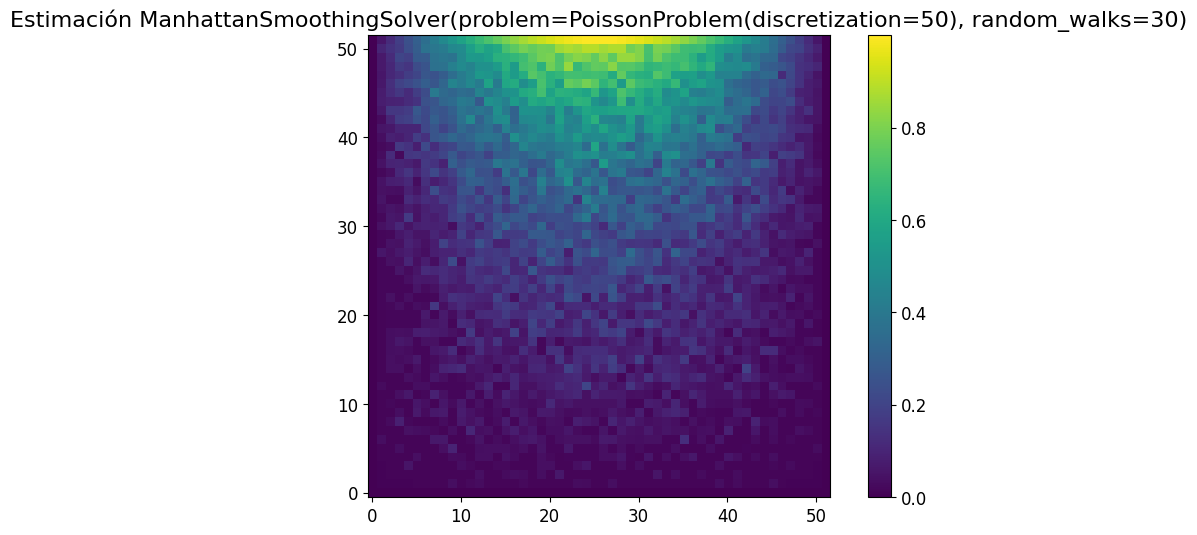

In [12]:
custom_smoothing = ManhattanSmoothingSolver(problema, 30)
plot_solution(custom_smoothing)

Como observación, aquí elegimos una cantidad de iteraciones no muy grande pues el tiempo de ejecución del algoritmo escala rápido con el número de iteraciones (con n=30 demora 40 segundos, con n = 50 2 minutos). Además, podemos estudiar los errores asociados:

In [13]:
def error(estimador, N=50):
    return ((estimador.grid - u_analitica(N))**2).sum()

In [14]:
estimadores = (frequentist, laplace_smoothing, custom_smoothing)
for estimador in estimadores:
    print(f"Error cuadrático {estimador}: {error(estimador)}")

Error cuadrático FrequentistSolver(problem=PoissonProblem(discretization=50), random_walks=30): 6.302253279629376
Error cuadrático LaplaceSmoothingSolver(problem=PoissonProblem(discretization=50), random_walks=30): 6.180990015724915
Error cuadrático ManhattanSmoothingSolver(problem=PoissonProblem(discretization=50), random_walks=30): 5.381444368557077


Se aprecia que ambos priors mejoran el desempeño del algoritmo, más aún nuestro prior personalizado.

Notamos ciertas debilidades del algoritmo propuesto en la literatura:

* El costo computacional para calcular u en todo el dominio es $O(Wn^3)$ en el mejor de los casos. 

* La información de un paseo solamente se utiliza para la estimación de u en un punto y luego se descarta.

## Algoritmo alternativo

Proponemos un algoritmo distinto que aprovecha la propiedad de Markov: Cada uno de los caminos tiene subcaminos que pueden usarse para mejorar la estimación. 

Visualizando subcaminos

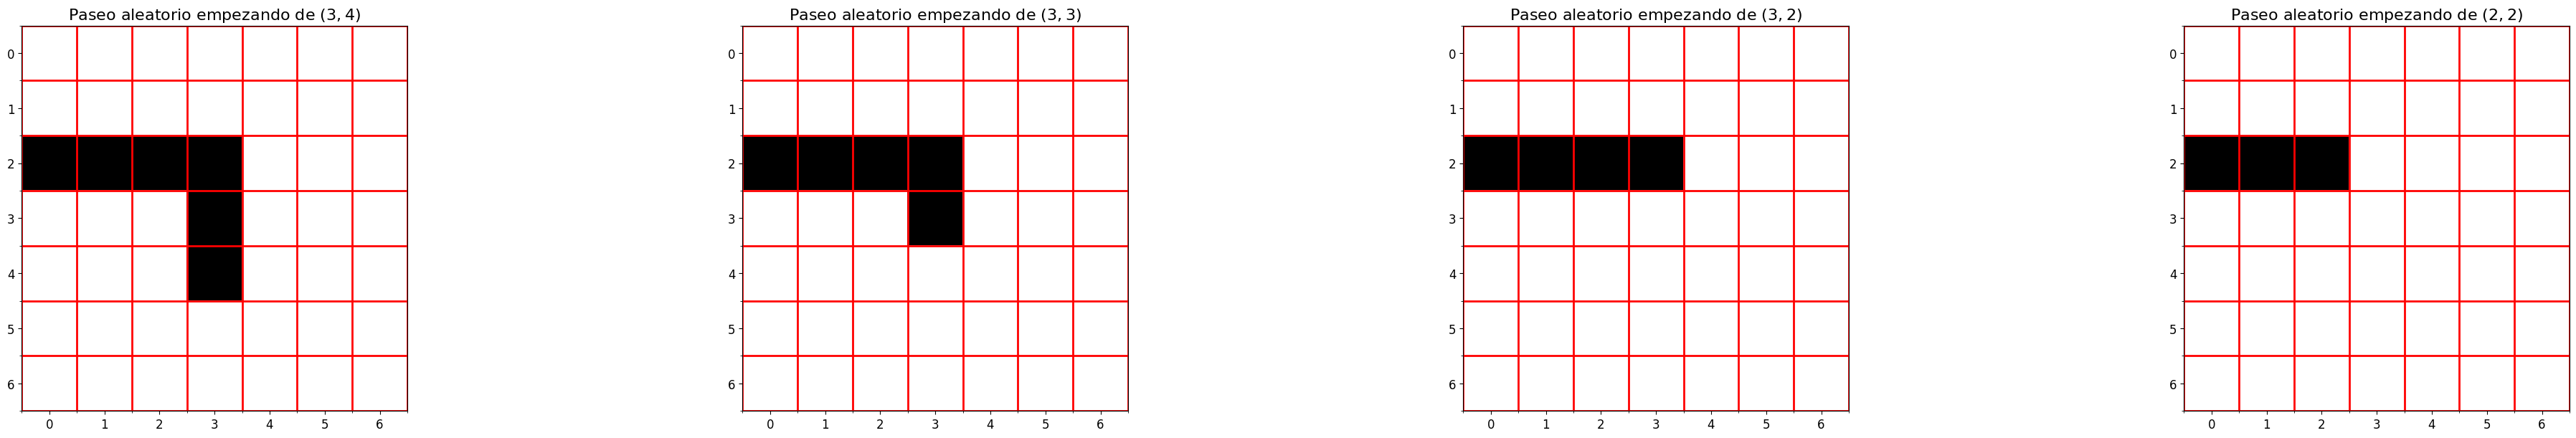

In [15]:
fig, axes = subplots(1, 4)
for ax in axes.flatten():
    # Major ticks
    ax.set_xticks(side)
    ax.set_yticks(side)

    # Labels for major ticks
    ax.set_xticklabels(side)
    ax.set_yticklabels(side)

    # Minor ticks
    ax.set_xticks(np.arange(-.5, discretization + 2), minor=True)
    ax.set_yticks(np.arange(-.5, discretization + 2), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='r', linestyle='-', linewidth=2)

ax = axes[0]
ax.imshow(grid.T, interpolation='none', vmin=0, vmax=1, aspect='equal', cmap="binary")
ax.set_title(r"Paseo aleatorio empezando de $(3, 4)$")

grid2 = grid.copy()
grid2[3, 4] = 0
ax = axes[1]
ax.imshow(grid2.T, interpolation='none', vmin=0, vmax=1, aspect='equal', cmap="binary")
ax.set_title(r"Paseo aleatorio empezando de $(3, 3)$")

grid3 = grid2.copy()
grid3[3, 3] = 0
ax = axes[2]
ax.imshow(grid3.T, interpolation='none', vmin=0, vmax=1, aspect='equal', cmap="binary")
ax.set_title(r"Paseo aleatorio empezando de $(3, 2)$");

grid4 = grid3.copy()
grid4[3, 2] = 0
ax = axes[3]
ax.imshow(grid4.T, interpolation='none', vmin=0, vmax=1, aspect='equal', cmap="binary")
ax.set_title(r"Paseo aleatorio empezando de $(2, 2)$");

Nuestro método mejorado busca generar de inmediato $u$ en $\Omega$ realizando también Montecarlo en el punto inicial.


0. Inicializar $U, P, R$ todos arreglos nulos en todas sus componentes
1. Inicializar arreglo $F$ con $F[x, y] = -f(x, y)h^2$
2. Repetir $W$ veces:

    2.1. Elegir aleatoriamente un punto interior $x_0$

    2.2. Correr un paseo aleatorio $w$ desde $x_0$ hasta $\xi$

    2.3. Para cada subcamino $w_i$ desde $x_i$ hasta $\xi$:

    2.3.1. Actualizar $P[x_i] += 1$

    2.3.2. Actualizar $R[x_i] += g(\xi)$

    2.3.2. Actualizar $U[x_i] += \sum_{i\in w\setminus \{\xi\}} F[x_i]$

3. Actualizar $U += R/P$

Acá $R$ se interpreta como los valores $g(\xi)C[\xi]$ del numerador de la expresión del algoritmo anterior. $P$ se interpreta por otro lado como los caminos totales que pasaron por el punto, y corresponde al denominador de la expresión del algoritmo anterior. $U$ almacena la solución final, durante las iteraciones se actualiza el término de $F(w)$ y al terminar todas estas se actualiza la otra sumatoria.

El último paso está bien definido si es que todos los puntos interiores han sido visitados (no se actualizan los puntos de borde pues los tenemos fijos por la condición de Dirichlet), por lo tanto debería elegirse $W$ suficientemente grande para garantizar esto. 

Otra opción es primero elegir el punto inicial aleatoriamente desde el conjunto de los puntos no visitados, para garantizar que todos se visiten, y luego de eso correr el algoritmo como especificado.

Implementar distintos priors corresponde a una distinta inicialización de $P$ y $R$, lo cual también resuelve el problema de indefinir $R/P$.


Implementamos nuestro algoritmo, con las siguientes consideraciones:

* Se elige el prior constante, que ya evidenció ser mejor que el estimador frecuentista y además es más fácil de implementar que nuestro prior personalizado.
* Para cada camino explorado $w$ se procesa además el camino antitético $N + 1 - w$, lo cual reduce la varianza del método.

/content/subwalk_monte_carlo_solvers.py:105: RuntimeWarning: invalid value encountered in true_divide
  self.grid[1:-1, 1:-1] += (self.border_contribution / self.walks_through_point)[1:-1, 1:-1]


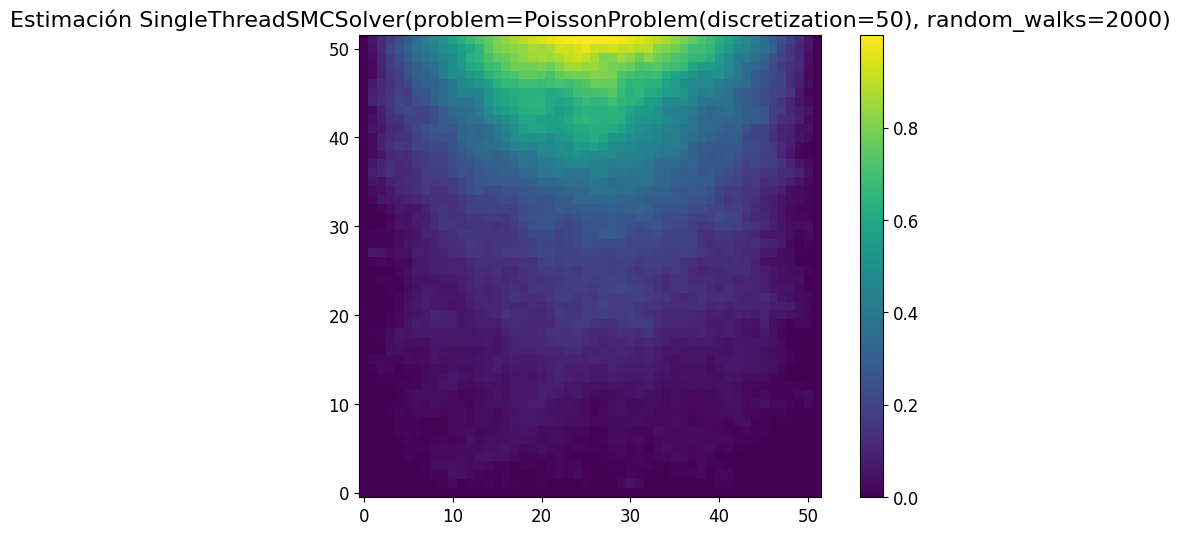

In [16]:
problema = PoissonProblem(50)
serial = SingleThreadSMCSolver(problema, 4*500)
plot_solution(serial)

Notamos que en este caso, con 2000 simulaciones de paseos aleatorios (es decir, 2000 iteraciones del algoritmo) la solución se ve bastante más suave que la dada por el algoritmo original con 75.000 simulaciones (es decir, 30 iteraciones por cada uno de los 50x50 puntos). Esto se deriva del hecho que este algoritmo "recicla" paseos, por lo tanto no necesita simular más como en caso del otro algoritmo. Cuantificaremos esta medida de eficacia más adelante.

Es importante destacar que ambos algoritmos (tanto el propuesto como el alternativo) son paralelizables, vale decir, pueden ser ejecutados de manera paralela por múltiples unidades de CPU (procesadores), lo cual es una de las ventajas de los métodos de Montecarlo que se discuten en la literatura. 

Nosotros elegimos dividir el dominio en 4 cuadrantes y procesar cada uno en paralelo en la generación de puntos iniciales. Esto no solamente mejora el tiempo de ejecución, sino que también estratifica el muestreo, reduciendo la varianza del método (y así el error de aproximación).

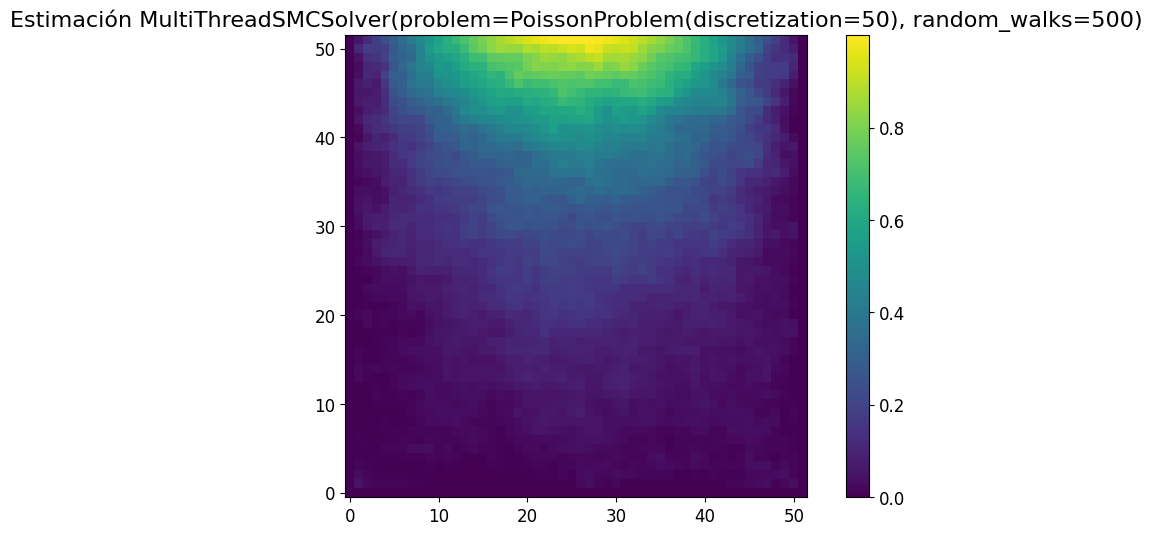

In [17]:
parallel = MultiThreadSMCSolver(problema, 500)
plot_solution(parallel)

In [18]:
for method in (serial, parallel):
    print(f"Error cuadrático {method}: {error(method)}")

Error cuadrático SingleThreadSMCSolver(problem=PoissonProblem(discretization=50), random_walks=2000): 1.3856914854259477
Error cuadrático MultiThreadSMCSolver(problem=PoissonProblem(discretization=50), random_walks=500): 1.3220017526542105


Primero que todo se observa que al implementar el algoritmo alternativo el error es mucho más pequeño que cualquier versión usada para el algoritmo propuesto. Además, el algoritmo alternativo paralelo tiene un error aun más pequeño que el algoritmo alternativo en serie. 

# Comparación con Diferencias finitas (Resolución Directa de EDP)

Se reutiliza nuestra implementación del laboratorio 1 con la versión de diferencias finitas usual para la EDP de Laplace (laplaciano discretizado con 5 puntos):

$$\Delta_{N}u_{j,k}=\dfrac{1}{h^{2}}\left(  u_{j+1,k}+u_{j-1,k}
+  u_{j,k-1}+u_{j,k+1}
-4u_{jk}\right)$$

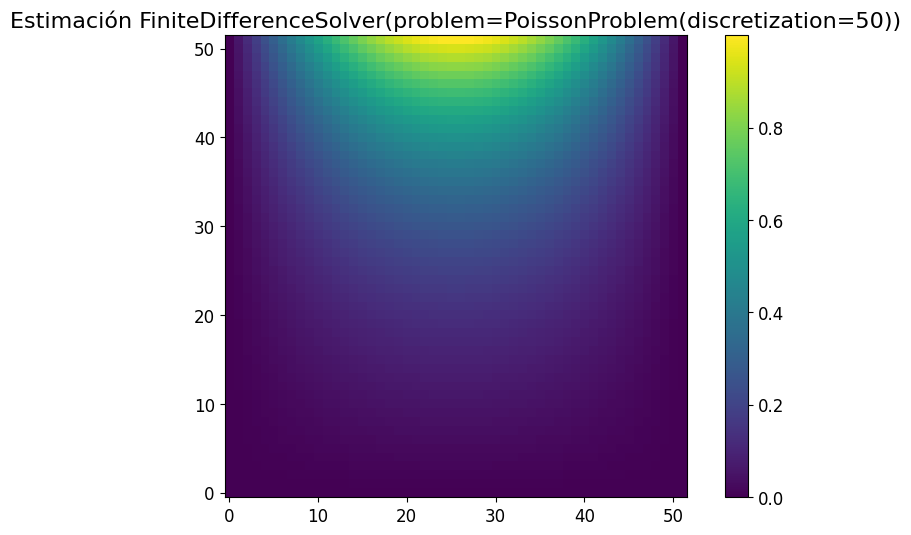

In [19]:
fd = FiniteDifferenceSolver(problema)
plot_solution(fd)

In [22]:
print(f"Error para diferencias finitas: {error(fd)}")

Error para diferencias finitas: 7.381834328131008e-06


# Conclusiones

* Métodos clásicos como diferencias finitas logran una aproximación más veloz y más exacta (menor error) a la solución de la EDP. Una de las razones de la mejora de velocidad es que los métodos clásicos de manejo de matrices están implementadas muy eficientemente con el paquete SciPy, desempeño que no se puede lograr con Python puro.
* Métodos de Montecarlo son más fáciles de modificar: Cambiar a un dominio perforado solamente requiere cambiar la detección de bordes en la simulación del paseo, mientras que en el caso de diferencias finitas hay que asegurarse de ajustar las matrices de tal forma que los puntos de la grilla no se salgan del dominio.
* El código para realizar simulaciones de Montecarlo no es complejo, pero nuestras modificaciones que mejoran velocidad y desempeño aumentan la complejidad del código.
* Los métodos de diferencias finitas sufren de la llamada maldición de la dimensionalidad, pues ~la matriz tiene tamaño O(n^{2k})~ requiere resolver un sistema de ecuaciones con $O(n^k)$ variables donde k es la dimensión del espacio, lo cual se logra en tiempo $O(n^{3k})$. Los métodos de Montecarlo no sufren esta debilidad de manera tan marcada, por lo cual podrían verse aventajados cuando $k>2$. Esto no se probó por limitaciones de tiempo. Más aún, se pueden realizar sin malla (eligiendo pasos uniformemente en $B(0, h)$), reduciendo el costo en memoria de $O(n^k)$ a posiblemente $O(1)$.

# BONUS: Métodos híbridos

Para resolver el sistema lineal $Au = b$, existen métodos iterativos de la forma:

$$
u_{k+1} = R(u_k)
$$

Donde $u_k\to u$ que satisface la ecuación. En particular, el método de gradiente conjugado garantiza convergencia en una cantidad finita de pasos cuando $A$ es semidefinida positiva (y existen variantes que relajan esta hipótesis, que se podrían usar en el caso del dominio perforado por ejemplo - por simplicidad nos mantenemos en este caso).

Estos métodos requieren un valor de inicio $u_0$, y mientras más cercano este sea a $u$, menos pasos le tomará converger. Por tanto, proponemos utilizar un método de Montecarlo para elegir $u_0$, considerando una cantidad pequeña de iteraciones. Luego, se utiliza un algoritmo iterativo para refinar a una solución más exacta.

Se espera que esto logre la misma precisión que la solución directa del sistema lineal, y que el buen punto de inicio pueda acelerar su obtención.

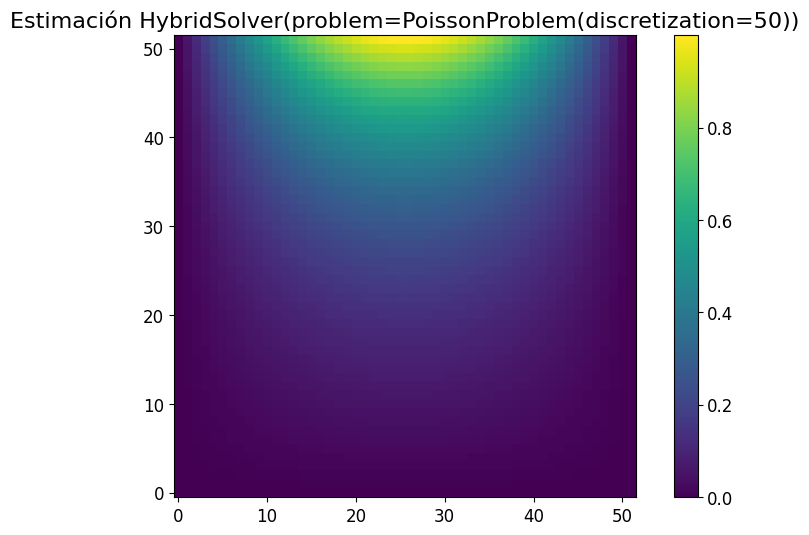

In [23]:
hybrid = HybridSolver(problema, 20)
plot_solution(hybrid)

In [24]:
print(f"Error para el método híbrido: {error(hybrid)}")

Error para el método híbrido: 7.4069690488427325e-06


El error es muy similar al de diferencias finitas, es decir, no hubo cambio significativo.

**Bibliografía**

* Library of Congress Cataloging in Publication Data
Numerical recipes in C : the art of scientific computing / William H. Press
... [et al.]. – 2nd ed.
ISBN 0-521-43108-5

* Cristóbal A. Navarro, Nancy Hitschfeld-Kahler & Luis Mateu. (2020). A Survey on Parallel Computing and Its Applications in Data-Parallel Problems Using GPU Architectures.
Communications in Computational Physics. 15 (2).
285-329.
doi:10.4208/cicp.110113.010813a

* Michael Mascagni. Monte Carlo Methods for
Partial Differential Equations. Department of Computer Science
Department of Mathematics
Department of Scientific Computing
Florida State University, Tallahassee, FL 32306 USA
URL: https://www.cs.fsu.edu/~mascagni/

* Michael Mascagni. Computational Geometry Aspects of Monte
Carlo Approaches to PDE Problems in
Biology, Chemistry, and Materials. Department of Computer Science
Department of Mathematics
Department of Scientific Computing
Florida State University, Tallahassee, FL 32306 USA
URL: https://www.cs.fsu.edu/~mascagni/

* Partial differential equations and Diffusion Processes - James Nolen

* https://github.com/s-ankur/montecarlo-pde/blob/master/Monte%20Carlo%20Methods%20Report.pdf

* Felipe Urrutia (2022): Placing gifs in a beamer presentation.
